# ANÁLISE DE GRANDE VOLUME DE DADOS - MsC - IPT-PT

## PROJETO 1

### JONATAS RIBEIRO

### AQUISIÇÃO, ARMAZENAMENTO E RECUPERAÇÃO DE DADOS EM LARGA ESCALA



## TAREFA 1 - FAMILIARIZAÇÃO COM A OBTENÇÃO DE DADOS A PARTIR DE FICHEIROS PDF

Optei por obter os 100 ficheiros de forma automatizada, a utilizar web scrapping.

O link utilizado para obtenção dos ficheiros é : <"https://openresearch.ceu.edu/browse?type=dateissued">

O principal tema são trabalhos acadêmicos da Central European University, a respeito de sociologia.

- Conjunto aproximado de 100 ficheiros em PDF na pasta "PDF_DATA_SOURCE"
- Tema: Sociologia Europeia
- Modo de obtenção: web scrapping
  - Selenium v4
    - obtenção de 100 urls de artigos científicos na Central European University
    - Página inicial disponibiliza apenas 20 items por vez
    - Carregar no Botão next até o limite de 100 itens atingido
    - Segunda parte do script é aceder a cada um dos links obtidos e realizar o download



## Pré-requisitos para esta task

Obter os 100 pdf´s de forma automatizada, através de web scrapping.

O código utilizado pode ser verificado nas boxes a seguir.

Não se faz necessário sua execução, uma vez que a pasta com o conteúdo extraido se encontra em meu Microsoft sharepoint
sharepoint:

- <https://politecnicotomar-my.sharepoint.com/:f:/g/personal/aluno26099_ipt_pt/Es_dk916aRZPhHvo-DKdekYBAmTehcrHRR4wFcZEVG6uJA?email=ricardo.campos%40ipt.pt&e=uUaouO>

Caso o utilizador deste notebook deseje verificar a execução do script de obtenção de pdfs, se faz necessária 
a instalação dos packages a seguir para a correta execução do script, entretanto, disponibilizo todo o conteúdo obtido através do script abaixo, na pasta nomeada `pdf_source`.

In [1]:
%pip install selenium
%pip install webdriver_manager

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from selenium import webdriver
import shutil
import os
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# if __name__ == "__main__":
    
driver = webdriver.Chrome()

driver.get("https://openresearch.ceu.edu/browse?type=dateissued")

article_url_count = 0
href_links = []
while article_url_count < 100:
    articles = driver.find_elements("css selector", ".description-content a")

    for article in articles:
        href_links.append(article.get_attribute("href"))
        article_url_count += 1
        if article_url_count == 100:
            break

    try:
        next_button = driver.find_element(By.CLASS_NAME, 'next-page-link')
        
        if next_button:
            next_button.click()
        else:
            break
    except:
        break


print("href_links:",href_links)

destination_folder = "pdf_source"
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    
for url in href_links:
    driver.get(url)
    
    download_button = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CLASS_NAME, 'file-download-button')))
    download_link = download_button.get_attribute('href')
    

    try:
        driver.get(download_link)

        file_name = download_link.split('/')[-1].split('?')[0]
        # time.sleep(20)  # Adjust the sleep time as needed

        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        time.sleep(20)  

        shutil.move(file_name, f"{destination_folder}/{file_name}")
    except Exception as e:
        print("An error occurred:", e)
        pass
    
driver.quit()



href_links: ['https://openresearch.ceu.edu/handle/20.500.14018/6495', 'https://openresearch.ceu.edu/handle/20.500.14018/14249', 'https://openresearch.ceu.edu/handle/20.500.14018/14248', 'https://openresearch.ceu.edu/handle/20.500.14018/14026', 'https://openresearch.ceu.edu/handle/20.500.14018/14027', 'https://openresearch.ceu.edu/handle/20.500.14018/14028', 'https://openresearch.ceu.edu/handle/20.500.14018/10059', 'https://openresearch.ceu.edu/handle/20.500.14018/7623', 'https://openresearch.ceu.edu/handle/20.500.14018/14029', 'https://openresearch.ceu.edu/handle/20.500.14018/10149', 'https://openresearch.ceu.edu/handle/20.500.14018/14030', 'https://openresearch.ceu.edu/handle/20.500.14018/11545', 'https://openresearch.ceu.edu/handle/20.500.14018/11547', 'https://openresearch.ceu.edu/handle/20.500.14018/11546', 'https://openresearch.ceu.edu/handle/20.500.14018/14252', 'https://openresearch.ceu.edu/handle/20.500.14018/9531', 'https://openresearch.ceu.edu/handle/20.500.14018/14031', 'htt

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=124.0.6367.119)
Stacktrace:
	GetHandleVerifier [0x00007FF7D5DD1502+60802]
	(No symbol) [0x00007FF7D5D4AC02]
	(No symbol) [0x00007FF7D5C07CE4]
	(No symbol) [0x00007FF7D5BDDFDF]
	(No symbol) [0x00007FF7D5C81E57]
	(No symbol) [0x00007FF7D5C998D1]
	(No symbol) [0x00007FF7D5C7A923]
	(No symbol) [0x00007FF7D5C48FEC]
	(No symbol) [0x00007FF7D5C49C21]
	GetHandleVerifier [0x00007FF7D60D411D+3217821]
	GetHandleVerifier [0x00007FF7D61160B7+3488055]
	GetHandleVerifier [0x00007FF7D610F03F+3459263]
	GetHandleVerifier [0x00007FF7D5E8B846+823494]
	(No symbol) [0x00007FF7D5D55F9F]
	(No symbol) [0x00007FF7D5D50EC4]
	(No symbol) [0x00007FF7D5D51052]
	(No symbol) [0x00007FF7D5D418A4]
	BaseThreadInitThunk [0x00007FFBF0F0257D+29]
	RtlUserThreadStart [0x00007FFBF272AA48+40]


### Extração de texto de cada ficheiro PDF e Ficheiro JSON com estrutura apropriada

Em seguida, com os documentos armazenados no ambiente de programação, preferencialmente na pasta nomeada:

'pdf_source'

O script a seguir é utilizado para a extração de informações (texto) de cada um dos pdf´s.

As informações consideradas relevantes são:
- author
- title
- abstract
- publication_date
- id

Com os dados relevantes, diversos itens são armazenadas e devidamente ordenados em um novo ficheiro JSON.

In [3]:
%pip install pdfplumber

Note: you may need to restart the kernel to use updated packages.


In [4]:
def get_publication_date(metadata):
    date = metadata.get('CreationDate', '')
    return date

In [12]:
import uuid

def generate_unique_id():
    return str(uuid.uuid4())

In [13]:
import pdfplumber

def extract_info_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        

        print("stating to extract info from pdf")
        info = {}
        info['id'] = generate_unique_id()
        info['authors'] = pdf.metadata.get('Author', '')
        info['title'] = pdf.metadata.get('Title', '')
        info['abstract'] = ''
        info['publication_date'] = get_publication_date(pdf.metadata)
        for page in pdf.pages:
            text = page.extract_text()
            if 'abstract' in text.lower():
                # Assuming abstract starts with the word "Abstract"
                abstract_index = text.lower().find('abstract')
                abstract = text[abstract_index:]
                info['abstract'] += abstract
        return info

In [15]:
# FILEPATH: /c:/Users/jonat/Documents/DEV/MESTRADO/MsC-IPT-Big-Data/PROJECTS/PROJ1/jonatas_ribeiro_pr1.ipynb
## Extract information from PDFs, using previous declared functions
import json

# if __name__ == '__main__':

# PROJECTS\PROJ1\PDF_DATA_SOURCE

pdf_folder = r'C:\Users\jonat\Documents\DEV\MESTRADO\MsC-IPT-Big-Data\PROJECTS\PROJ1\pdf_source'
output_data = []

for file_name in os.listdir(pdf_folder):
    if file_name.endswith('.pdf'):
        print("pdf file found", file_name)
        pdf_path = os.path.join(pdf_folder, file_name)
        info = extract_info_from_pdf(pdf_path)
        output_data.append(info)
print("output_data:",output_data)        
output_file = 'extracted_info.json'
with open(output_file, 'w') as json_file:
    json.dump(output_data, json_file, indent=4)
    
print(f"Extracted information saved to {output_file}")

pdf file found 06-1-03.pdf
stating to extract info from pdf
pdf file found 68-homoclinic-solutions-of-a-fourth-order-travelling-wav.pdf
stating to extract info from pdf
pdf file found aceee-kyoto-flex-mex-2006-p8-488-rn.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 1993_4.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 1994_5.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 1995_6.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 1996_7.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 1997_8.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 2000.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 2001.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 2002.pdf
stating to extract info from pdf
pdf file found Annual of Medieval Studies 2003.pdf
stating to


### Conteúdo do ficheiro JSON e nuvem de palavras

Para a criação da nuvem de palavras, foi utilizada a biblioteca wordCloud, com base nos abstracts e titles obtidos.

In [16]:
%pip install wordcloud
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



In [17]:
## opening JSON file function

def open_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

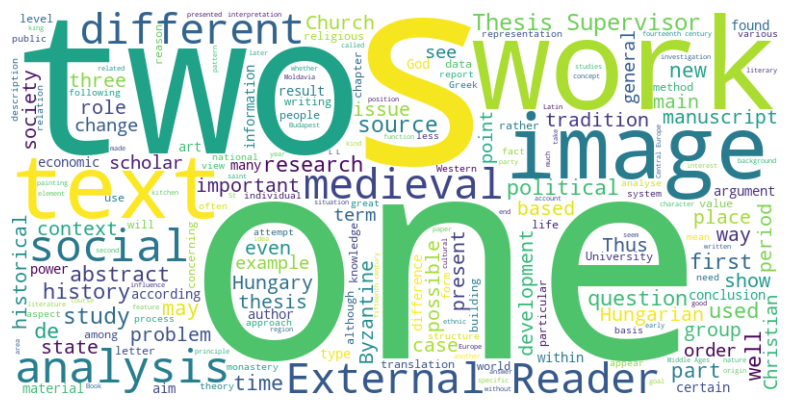

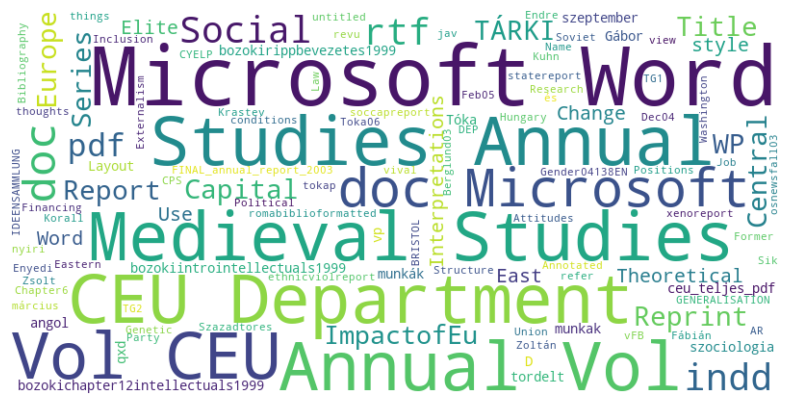

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# if __name__ == '__main__':

## main function to generate word clouds
    
data = open_json_file('extracted_info.json')
abstracts_text = ' '.join(item['abstract'] for item in data)
word_cloud = WordCloud(width=800, height=400, background_color='white').generate(abstracts_text)

abstracts_text = ' '.join(item['title'] for item in data)
word_cloud2 = WordCloud(width=800, height=400, background_color='white').generate(abstracts_text)

## Abstract word cloud
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Title word cloud
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
## iterate over the first 5 items in the data and print information

for item in data[:5]:
        print("ID:", item['id'])
        print("Authors:", item['authors'])
        print("Title:", item['title'])
        print("Abstract:", item['abstract'])
        print()

ID: 70f6b554-137c-4728-9fae-867b7a4c4b70
Authors: 
Title: 
Abstract: 

ID: 5416e765-ccaf-4c0c-a6bc-6582f2ef5deb
Authors: 
Title: 
Abstract: 

ID: d88489f8-8789-46c3-bbd4-0a8d19e55853
Authors: Renee Nida
Title: Title (Use “Title” style here)
Abstract: ABSTRACT
According to their design, the flexible mechanisms of the Kyoto Protocol should deliver a
wide spectrum of “magical” outcomes in all sectors of developing countries and transition
economies including, among others, technology and know-how transfer, skilled experts,
investment capital, and capacity building. Buildings should, in theory, be prime targets of clean
development mechanism (CDM) and joint implementation (JI) projects since they house major
cost-effective potentials for saving carbon-dioxide (CO2) through the improvement of energy
efficiency all around the world. Host countries should welcome activities channeled to
buildings, as these mechanisms could help overcome barriers inhibiting the improvement of
energy efficiency

## TAREFA 2 - Familiarização com a obtenção de dados a partir de packages Python

- A utilizar o recurso do package do wikipedia para a criação de um dataset com 2000 imagens
- Dois temas distintos
  - Design
  - Restaurants

Disponibilizo a pasta partilhada com o download realizado de 2000 imagens:

- <https://politecnicotomar-my.sharepoint.com/:f:/g/personal/aluno26099_ipt_pt/Eg8VdHKeNPlJipYZazCRanABaKpougjpEtpKvWkOnFQyQg?email=ricardo.campos%40ipt.pt&e=7aXO3A>

A seguir, o script utilizado para a obtenção do dataset utilizando o package 'wikipedia'.


In [20]:
## installing necessary packages

%pip install wikipedia

In [21]:
import wikipedia
# query wikipedia for a given search term

def search_wikipedia(query, results=10):
    return wikipedia.search(query, results=results)

In [22]:
# download image function
def download_image(article):
    images = []
    
    print("Downloading images for article:", article)
    try:
        page = wikipedia.page(article)
        print("Found page:", page.images)
        images = page.images
        for image in images:
            if image.endswith(('.jpg', '.jpeg', '.png', '.gif')):
                print("Found image:", image)
                if image:
                    images.append(image)
        return images
    except wikipedia.exceptions.DisambiguationError as e:
        # Skip disambiguation pages
        pass
    except wikipedia.exceptions.PageError as e:
        print(f"Page not found for article: {article}")
        pass
    except KeyError as e:
        print(f"KeyError: {e}")
        pass

In [ ]:
## save images to a folder function
import requests  
  
def try_to_save_image(url, i, save_dir):
    print(f"Downloading image {i}: {url}")
    try:
        response = requests.get(url)
        extension = url.split('.')[-1]
        with open(save_dir + f'image_{i}.{extension}', 'wb') as f:
            f.write(response.content)
    except Exception as e:
        print(f"Error downloading image {i}: {e}")
        pass

In [ ]:
# main function  

# if __name__ == "__main__":
    
print("starting the script")

design_articles = search_wikipedia("Design", results=1000)
restaurant_articles = search_wikipedia("Restaurant", results=1000)

articles = design_articles + restaurant_articles

print(articles)

image_urls = []

for article in articles:
    download_image(article)

save_dir = 'image_dataset/'

#Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, url in enumerate(image_urls):

    try_to_save_image(url, i, save_dir)

print("Script finished")

## TAREFA 3 - Familiarização com Web Scraping

- A utilizar o recurso de web scrapping do Selenium v4
- O tema principal é a obtenção de informações sobre o parlamento Europeu, nomeadamente: 
  - ùltimas notícias relevantes
  - Próximos eventos agendados
- Os dados são disponibilizados em uma lista final de dicionários (objetos), afim de facilitar o consumo da informação
em outras aplicações.


In [ ]:
%pip install selenium

In [ ]:
TARGET_URL = "https://www.europarl.europa.eu/news/pt"


In [ ]:
# webdriver functions
# using Chrome to access web

def init_driver():
    driver = webdriver.Chrome()
    return driver

def quit_driver():
    driver.quit()

In [ ]:
def get_last_news(id,driver):
    try:
        # Get the last news
        news = driver.find_elements(By.CLASS_NAME, id)
        return news
    except Exception as e:
        print("An error occurred:", e)
        return None

In [ ]:
def get_next_events_list(id,driver):
    
    try:
        event_list_element = driver.find_element(By.ID, id)
        list_items = event_list_element.find_elements(By.TAG_NAME, "li")

        return list_items
    except Exception as e:
        print("No list elements found:", e)
        return None

In [ ]:
def get_event_context(event):
    try:
        date_element = event.find_element(By.CLASS_NAME, "ep_date")
        date = date_element.text.strip()
        
        type_element = event.find_element(By.CLASS_NAME, "ep_type")
        event_type = type_element.text.strip()
        
        # Extract the event title
        title_element = event.find_element(By.CLASS_NAME, "ep_title")
        title = title_element.text.strip()
        
        # Extract the event location
        location_element = event.find_element(By.CLASS_NAME, "ep_location")
        location = location_element.text.strip()
    
     # Print the extracted information for each event
        print("Date:", date)
        print("Type:", event_type)
        print("Title:", title)
        print("Location:", location)
        print() 
        return {date, event_type, title, location}
    except Exception as e:
        print("An error occurred:", e)
        return None

In [ ]:

def get_news_context(news):
    
    # print("Extracting news context...",news)
    try:
        # Get the news context
        title_element = news.find_element(By.CLASS_NAME, "ep_title")
        title = title_element.text
        
        # date_element = news.find_element(By.CSS_SELECTOR, "time[itemprop='datePublished']")
        # date = date_element.get_attribute("datetime")
        
        content_element = news.find_element(By.CLASS_NAME, "ep-a_text")
        content = content_element.text
        
        if len(title) > 0 and len(content) > 0:
        
            # print("Title:", title)
            # print("Publication Date:", date)  
            # print("Content:", content)
            return {title, content}
        else:
            pass
    except Exception as e:
        print("An error occurred:", e)
        return None

In [ ]:
#main script to obtain desired information

# if __name__ == "__main__":
driver = init_driver()

driver.get(TARGET_URL)

extracted_news = get_last_news("ep_gridcolumn",driver)
# if len(extracted_news) >5:
#     extracted_news = extracted_news[:5]
# print("Extracted news:", extracted_news)
final_news = []
for news in extracted_news:
    new = get_news_context(news)
    if new != None:
        final_news.append(new)
        # print("New:", new)
print("Final news:", final_news)

final_event_list = []
extracted_next_events = get_next_events_list("event-list",driver)

for event in extracted_next_events:
    event = get_event_context(event)
    if event != None:
        final_event_list.append(event)
        # print("Event:", event)
print("Final event list:", final_event_list)

quit_driver()

## TAREFA 4 - Familiarização com a obtenção de dados a partir de APIs

- A utilizar o recurso de requisição web requests para a chamada de uma API gratuíta
- O tema principal é relacionado as frases do famoso 'chuck norris' 
- Os dados são obtidos a cada 30 minutos
- Uma VM foi provisionada no Microsoft Azure, para executar o script python
- Os logs estão a ser gravados em um ficheiro a parte, para o registo do status da requisição e seu conteúdo
- O ficheiro log é finalmente convertido para JSON

Minha maior dificuldade após o término do script de aquisição de dados da API na VM, foi exatamente o download dos 
ficheiros.

Para isso, se fez necessário a configuração de SSH e o uso do terminal com o comando 'SCP' 

Abaixo, o link para acesso a pasta que contém os logs, armazenados no sharepoint:

- <https://politecnicotomar-my.sharepoint.com/:f:/g/personal/aluno26099_ipt_pt/EvEawYLBSsBFpqZFYOa-pdoBPGKo41IHpa3GFp_K2d-pAw?email=ricardo.campos%40ipt.pt&e=mP0wRV>

In [ ]:
import requests
import logging
import time

logging.basicConfig(filename='api_data.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def retrieve_data_from_api():
    try:
        url = "https://matchilling-chuck-norris-jokes-v1.p.rapidapi.com/jokes/random"

        headers = {
            "accept": "application/json",
            "X-RapidAPI-Key": "aa24d1a197msh7c322f1111480c2p16c025jsn35b22e6582d6",
            "X-RapidAPI-Host": "matchilling-chuck-norris-jokes-v1.p.rapidapi.com"
        }
        response = requests.get(url, headers=headers)

        print(response.json())
        
        
        response = requests.get(url, headers=headers)

        logging.info(f'Data retrieved successfully from the API: {response.json()}')
    except Exception as e:
        print(f'An error occurred: {str(e)}')
        logging.error(f'An error occurred: {str(e)}')
        
def job():
    print("Job started")
    retrieve_data_from_api()

In [ ]:
# if __name__ == "__main__":

print("Init script")
	#schedule.every().hour.do(job)
for _ in range(24 * 5):
    print("Attempt:",_)
    job()
    #schedule.run_pending()
    time.sleep(1800)

Com o código acima, realizei o logging das chamadas a API do chuck norris.

Em seguida, tenho que realizar o parse dos logs para o formato JSON.

Os logs estão na pasta chamada data_logs.

In [ ]:
import os
import json
from ast import literal_eval

def process_log_file(log_file):
    parsed_logs = []
    with open(log_file, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parsed_logs.append(parse_log_line(line))
    
    return parsed_logs

def parse_log_line(line):
    print("parsing log line:",line)
    json_content = line.split('{', 1)[1].rsplit('}', 1)[0]
    print("json_content:",json_content)
    
    data_dict = literal_eval("{" + json_content + "}")
    # Parse the JSON content
    return {
        'log_data': data_dict
    }
def main(logs_folder, output_file):
    all_logs = []
    for filename in os.listdir(logs_folder):
        if filename.endswith('.log'):
            log_file = os.path.join(logs_folder, filename)
            all_logs.extend(process_log_file(log_file))
    
    json_logs = json.dumps(all_logs, indent=4)
    
    with open(output_file, 'w') as f:
        f.write(json_logs)
        
        
# PROJECTS\PROJ1\data_logs
# if __name__ == "__main__":
logs_folder = 'data_logs'
output_file = 'api_response_2.json'
main(logs_folder, output_file)


O código acima irá produzir um ficheiro JSON, com o conteúdo da minha API.

Para iterar sobre os 5 primeiros items do meu ficheiro, podemos utilizar o código abaixo:

In [ ]:
import json

filename = 'api_response_2.json'  
with open(filename, 'r') as f:
    data = json.load(f)

for item in data[:5]:
    log_data = item['log_data']
    print("ID:", log_data['id'])
    print("Value:", log_data['value'])
    print("Categories:", log_data['categories'])
    print("Created At:", log_data['created_at'])
    print("Updated At:", log_data['updated_at'])
    print("Icon URL:", log_data['icon_url'])
    print("URL:", log_data['url'])
    print()

## TAREFA 5 - Familiarização com o armazenamento e recuperação de dados em larga escala 

- A utilizar o recurso do redis + docker

Primeiramente, é necessário garantir que 'docker' está corretamente instalado na máquina.

Em seguida, utilizar a imagem oficial do 'REDIS', disponível em 'Docker Hub'.


'docker run --name proj1 -d -p 6379:6379 redis' 

Em seguida instalar o package do redis

In [ ]:
%pip install redis

In [ ]:
import json
import redis

filename = 'api_response_2.json'  # Replace with your JSON file path
with open(filename, 'r') as f:
    data = json.load(f)

r = redis.Redis(host='localhost', port=6379, db=0)

# Index the JSON data into Redis
for i, item in enumerate(data):
    r.set(f'item:{i}', json.dumps(item))